In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


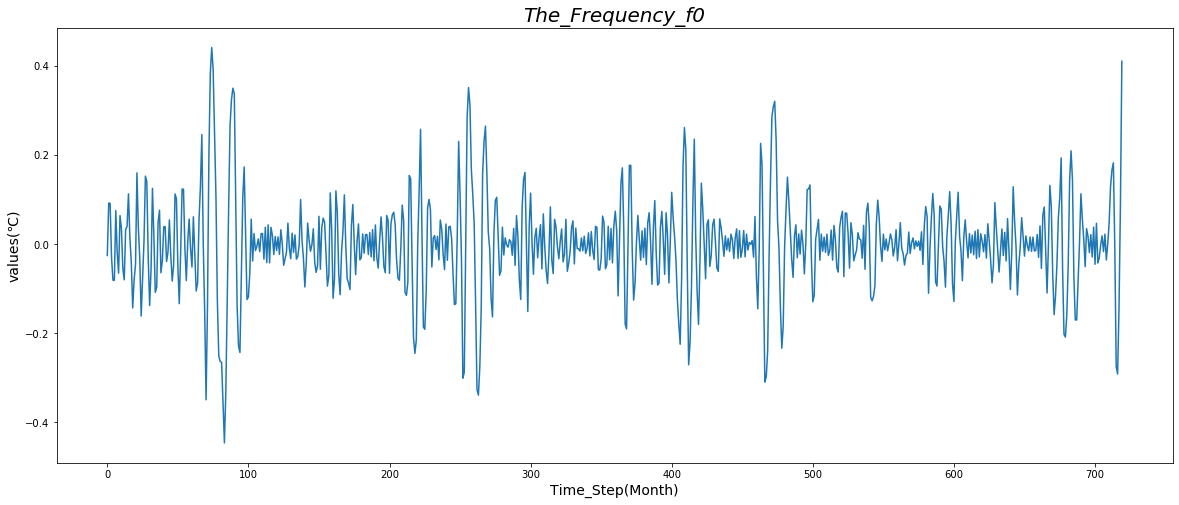

(672, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 19s - loss: 0.0109
Epoch 2/200
 - 4s - loss: 0.0108
Epoch 3/200
 - 3s - loss: 0.0108
Epoch 4/200
 - 3s - loss: 0.0108
Epoch 5/200
 - 3s - loss: 0.0108
Epoch 6/200
 - 3s - loss: 0.0108
Epoch 7/200
 - 3s - loss: 0.0108
Epoch 8/200
 - 3s - loss: 0.0108
Epoch 9/200
 - 3s - loss: 0.0108
Epoch 10/200
 - 3s - loss: 0.0107
Epoch 11/200
 - 3s - loss: 0.0107
Epoch 12/200
 - 3s - loss: 0.0106
Epoch 13/200
 - 3s - loss: 0.0105
Epoch 14/200
 - 3s - loss: 0.0102
Epoch 15/200
 - 3s - loss: 0.0101
Epoch 16/200
 - 3s - loss: 0.0100
Epoch 17/200
 - 3s - loss: 0.0101
Epoch 18/200
 - 3s - loss: 0.0102
Epoch 19/200
 - 3s - loss: 0.0096
Epoch 20/200
 - 3s - loss: 0.0097
Epoch 21/200
 - 3s - loss: 0.0097
Epoch 22/200
 - 3s - loss: 0.0096
Epoch 23/200

(57, 12)


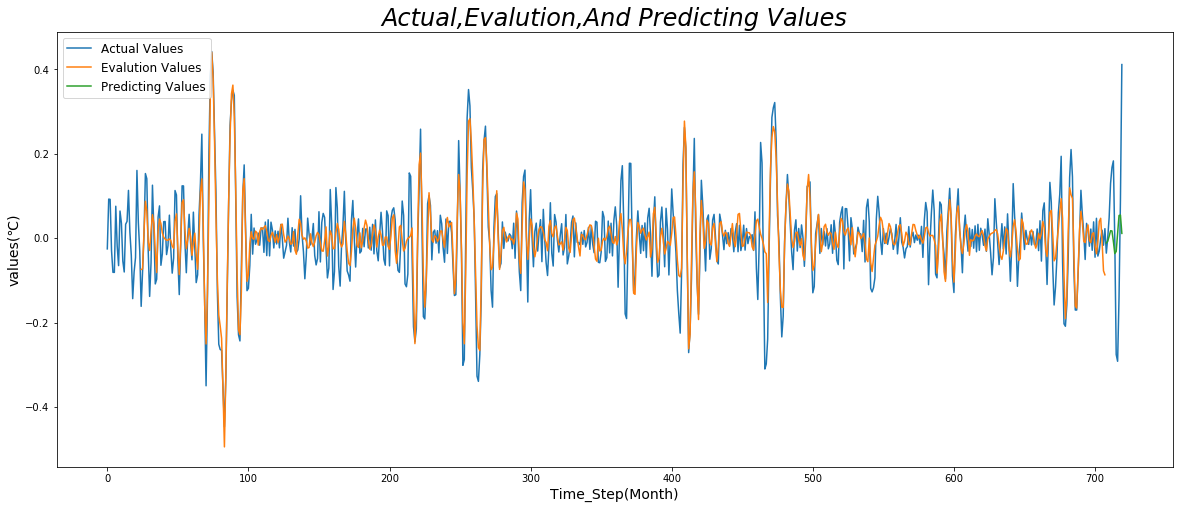

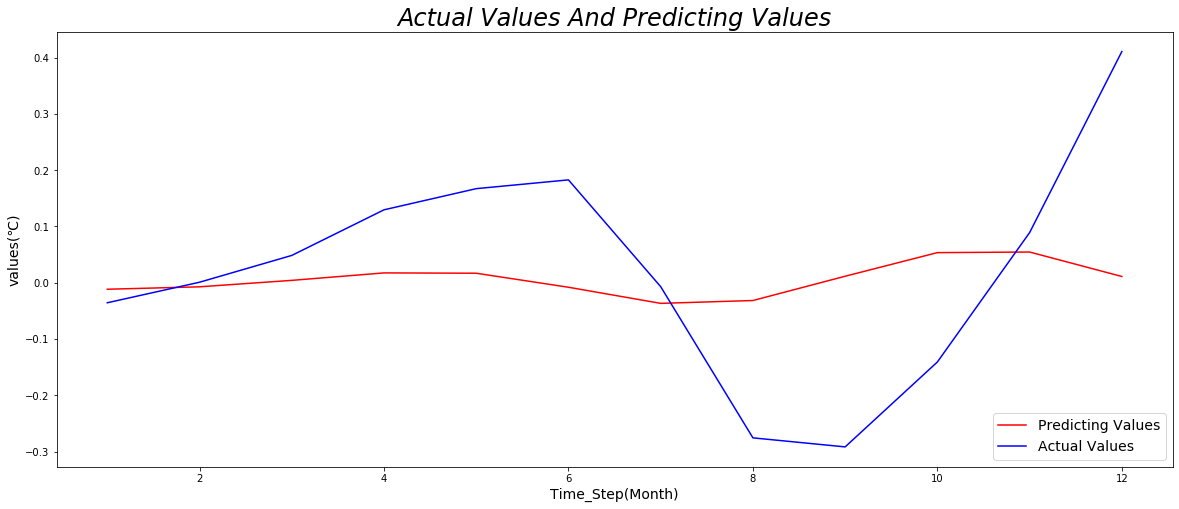

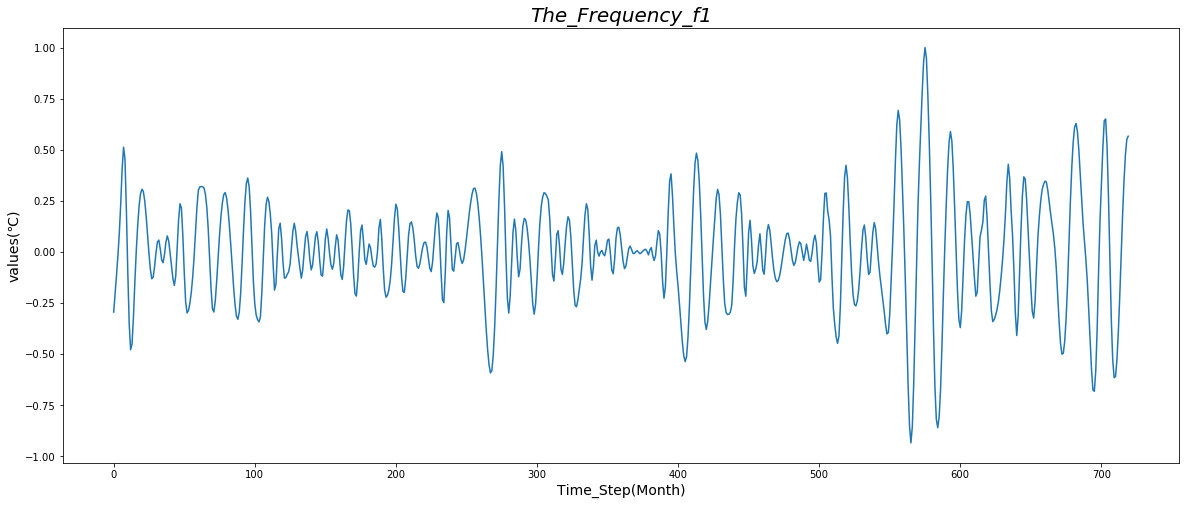

(672, 24, 1)
Epoch 1/200
 - 20s - loss: 0.0627
Epoch 2/200
 - 4s - loss: 0.0577
Epoch 3/200
 - 4s - loss: 0.0512
Epoch 4/200
 - 4s - loss: 0.0484
Epoch 5/200
 - 4s - loss: 0.0445
Epoch 6/200
 - 4s - loss: 0.0425
Epoch 7/200
 - 4s - loss: 0.0408
Epoch 8/200
 - 4s - loss: 0.0420
Epoch 9/200
 - 4s - loss: 0.0410
Epoch 10/200
 - 4s - loss: 0.0396
Epoch 11/200
 - 4s - loss: 0.0370
Epoch 12/200
 - 4s - loss: 0.0363
Epoch 13/200
 - 4s - loss: 0.0372
Epoch 14/200
 - 4s - loss: 0.0367
Epoch 15/200
 - 4s - loss: 0.0353
Epoch 16/200
 - 4s - loss: 0.0362
Epoch 17/200
 - 4s - loss: 0.0355
Epoch 18/200
 - 4s - loss: 0.0322
Epoch 19/200
 - 4s - loss: 0.0313
Epoch 20/200
 - 4s - loss: 0.0322
Epoch 21/200
 - 4s - loss: 0.0321
Epoch 22/200
 - 4s - loss: 0.0298
Epoch 23/200
 - 4s - loss: 0.0299
Epoch 24/200
 - 4s - loss: 0.0301
Epoch 25/200
 - 4s - loss: 0.0290
Epoch 26/200
 - 4s - loss: 0.0285
Epoch 27/200
 - 4s - loss: 0.0284
Epoch 28/200
 - 4s - loss: 0.0271
Epoch 29/200
 - 4s - loss: 0.0273
Epoch 30/

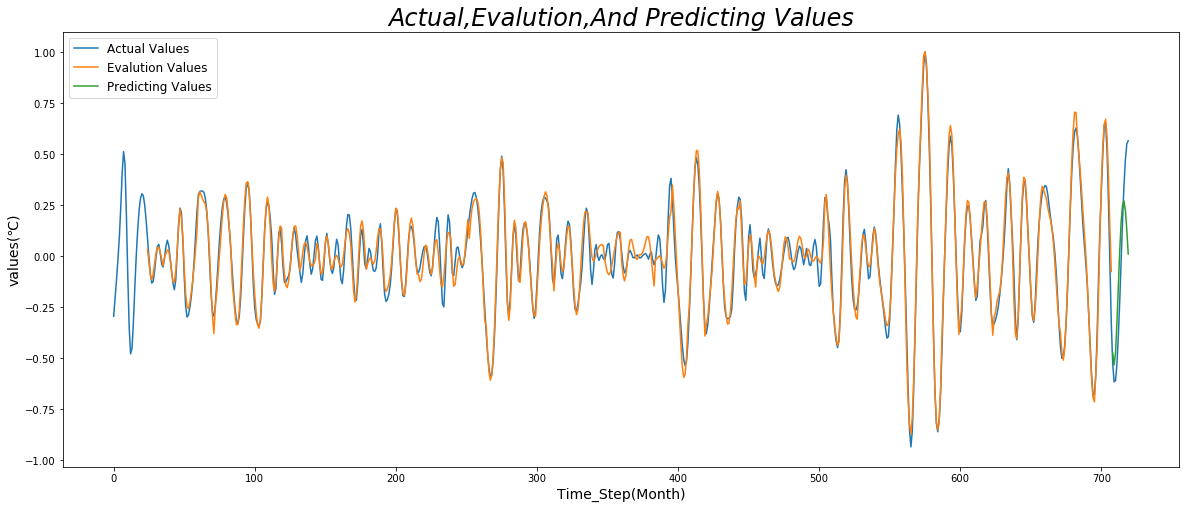

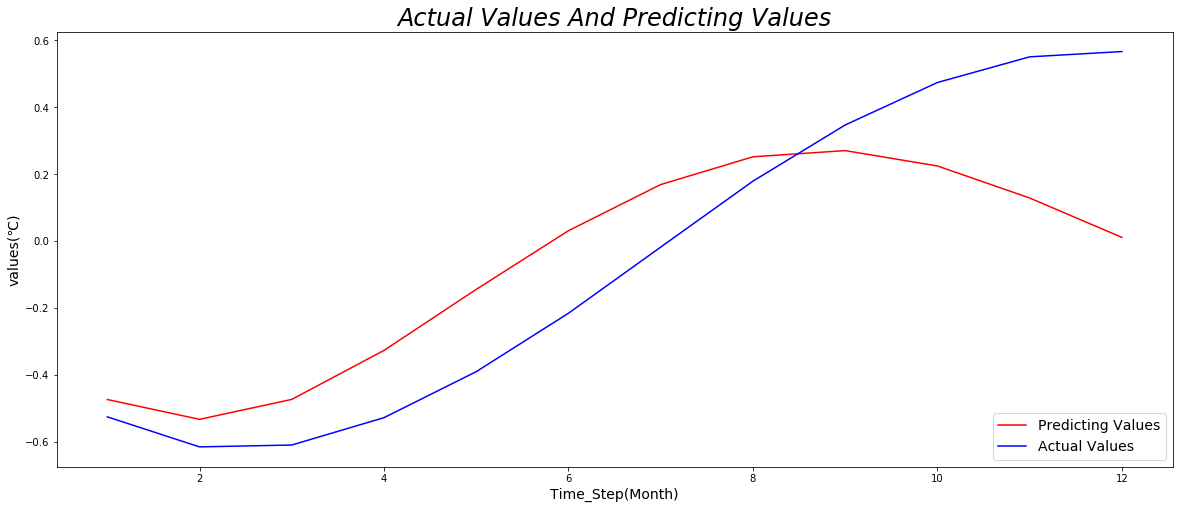

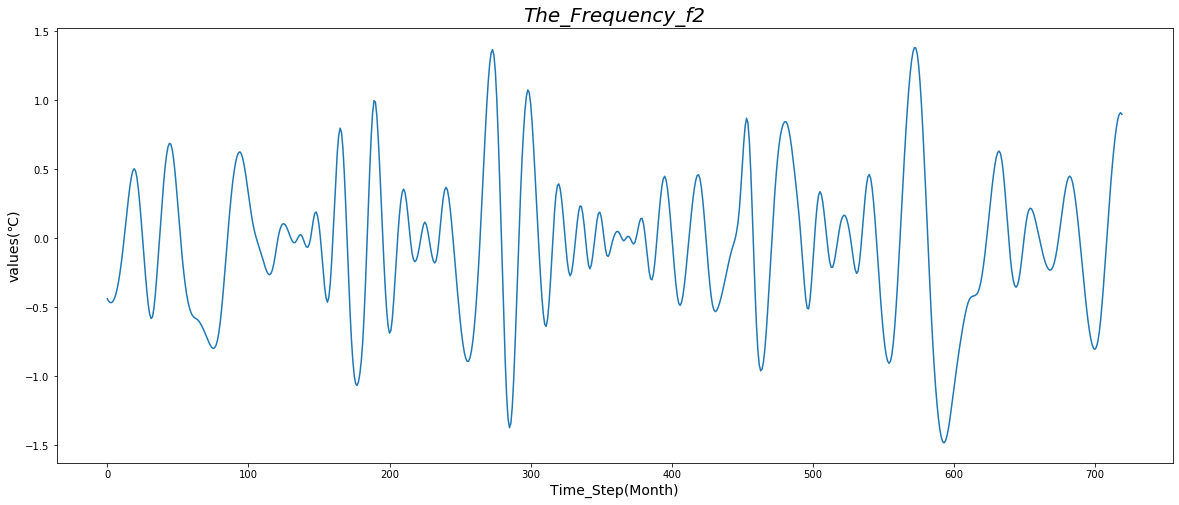

(672, 24, 1)
Epoch 1/200
 - 11s - loss: 0.2591
Epoch 2/200
 - 4s - loss: 0.2434
Epoch 3/200
 - 4s - loss: 0.2308
Epoch 4/200
 - 4s - loss: 0.2164
Epoch 5/200
 - 4s - loss: 0.1822
Epoch 6/200
 - 4s - loss: 0.1571
Epoch 7/200
 - 4s - loss: 0.1362
Epoch 8/200
 - 4s - loss: 0.1309
Epoch 9/200
 - 4s - loss: 0.1178
Epoch 10/200
 - 4s - loss: 0.1146
Epoch 11/200
 - 4s - loss: 0.1078
Epoch 12/200
 - 4s - loss: 0.0981
Epoch 13/200
 - 4s - loss: 0.0979
Epoch 14/200
 - 4s - loss: 0.0903
Epoch 15/200
 - 4s - loss: 0.0858
Epoch 16/200
 - 4s - loss: 0.0915
Epoch 17/200
 - 4s - loss: 0.0839
Epoch 18/200
 - 4s - loss: 0.0813
Epoch 19/200
 - 4s - loss: 0.0746
Epoch 20/200
 - 4s - loss: 0.0712
Epoch 21/200
 - 4s - loss: 0.0701
Epoch 22/200
 - 4s - loss: 0.0659
Epoch 23/200
 - 4s - loss: 0.0687
Epoch 24/200
 - 4s - loss: 0.0594
Epoch 25/200
 - 4s - loss: 0.0598
Epoch 26/200
 - 4s - loss: 0.0718
Epoch 27/200
 - 4s - loss: 0.0585
Epoch 28/200
 - 4s - loss: 0.0590
Epoch 29/200
 - 4s - loss: 0.0546
Epoch 30/

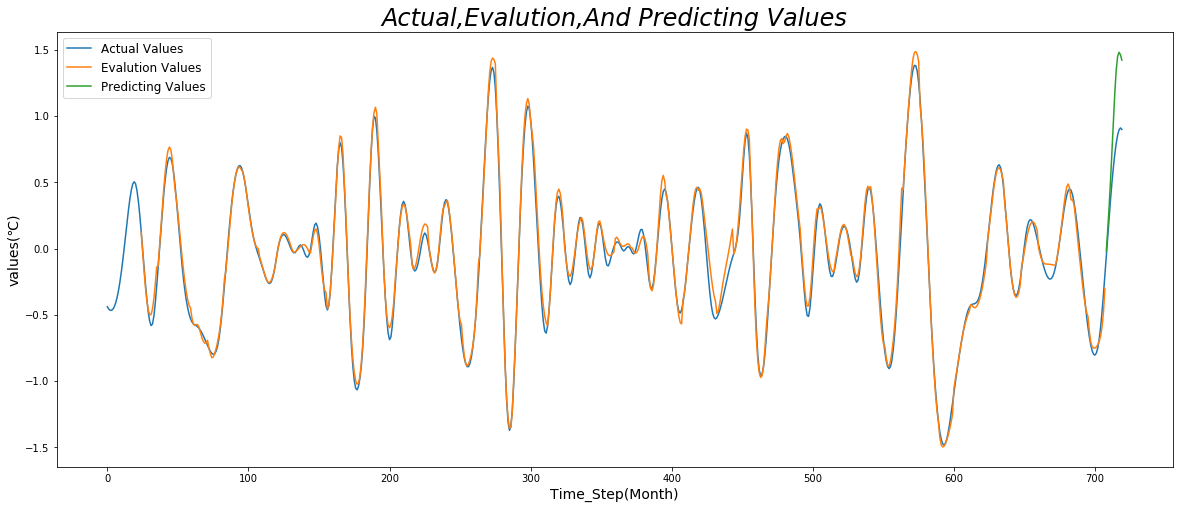

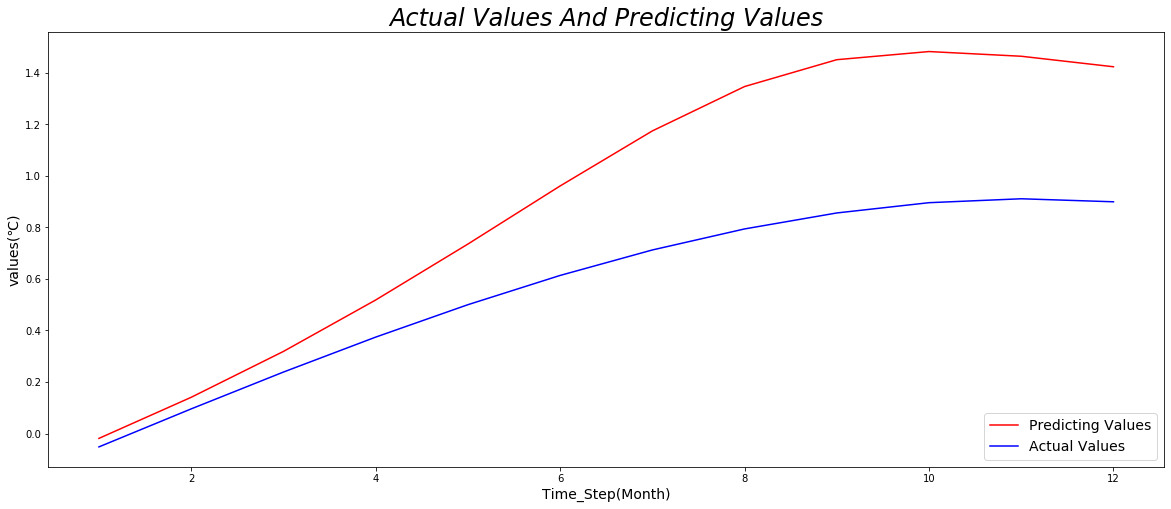

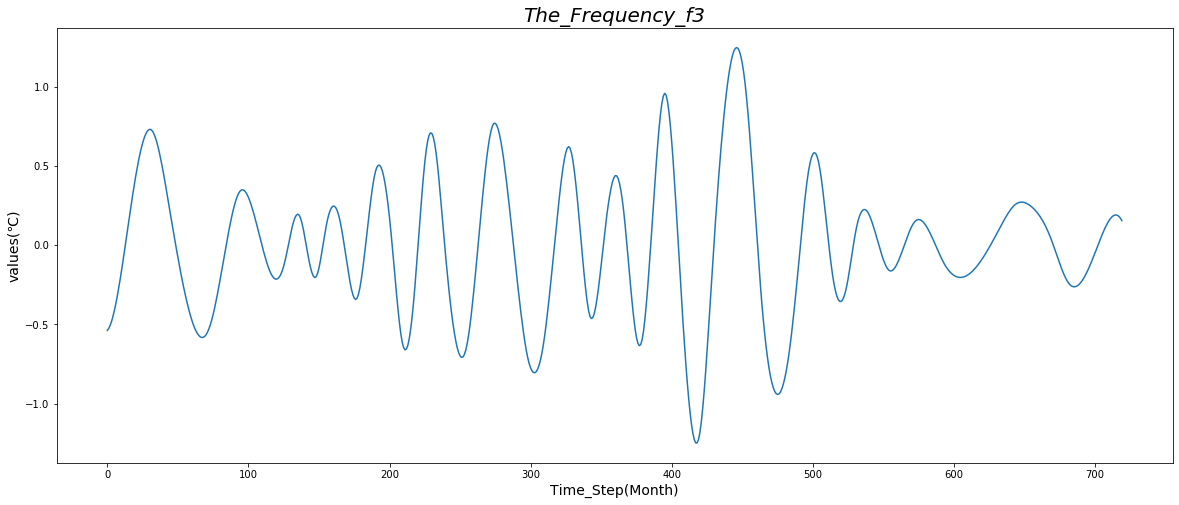

(672, 24, 1)
Epoch 1/200
 - 11s - loss: 0.1647
Epoch 2/200
 - 4s - loss: 0.1302
Epoch 3/200
 - 4s - loss: 0.0937
Epoch 4/200
 - 4s - loss: 0.0720
Epoch 5/200
 - 4s - loss: 0.0552
Epoch 6/200
 - 4s - loss: 0.0467
Epoch 7/200
 - 4s - loss: 0.0420
Epoch 8/200
 - 4s - loss: 0.0289
Epoch 9/200
 - 4s - loss: 0.0266
Epoch 10/200
 - 4s - loss: 0.0267
Epoch 11/200
 - 4s - loss: 0.0239
Epoch 12/200
 - 4s - loss: 0.0236
Epoch 13/200
 - 4s - loss: 0.0179
Epoch 14/200
 - 4s - loss: 0.0186
Epoch 15/200
 - 4s - loss: 0.0185
Epoch 16/200
 - 4s - loss: 0.0167
Epoch 17/200
 - 4s - loss: 0.0165
Epoch 18/200
 - 4s - loss: 0.0162
Epoch 19/200
 - 4s - loss: 0.0164
Epoch 20/200
 - 4s - loss: 0.0184
Epoch 21/200
 - 4s - loss: 0.0142
Epoch 22/200
 - 4s - loss: 0.0134
Epoch 23/200
 - 4s - loss: 0.0133
Epoch 24/200
 - 4s - loss: 0.0123
Epoch 25/200
 - 5s - loss: 0.0153
Epoch 26/200
 - 4s - loss: 0.0179
Epoch 27/200
 - 4s - loss: 0.0201
Epoch 28/200
 - 4s - loss: 0.0122
Epoch 29/200
 - 4s - loss: 0.0112
Epoch 30/

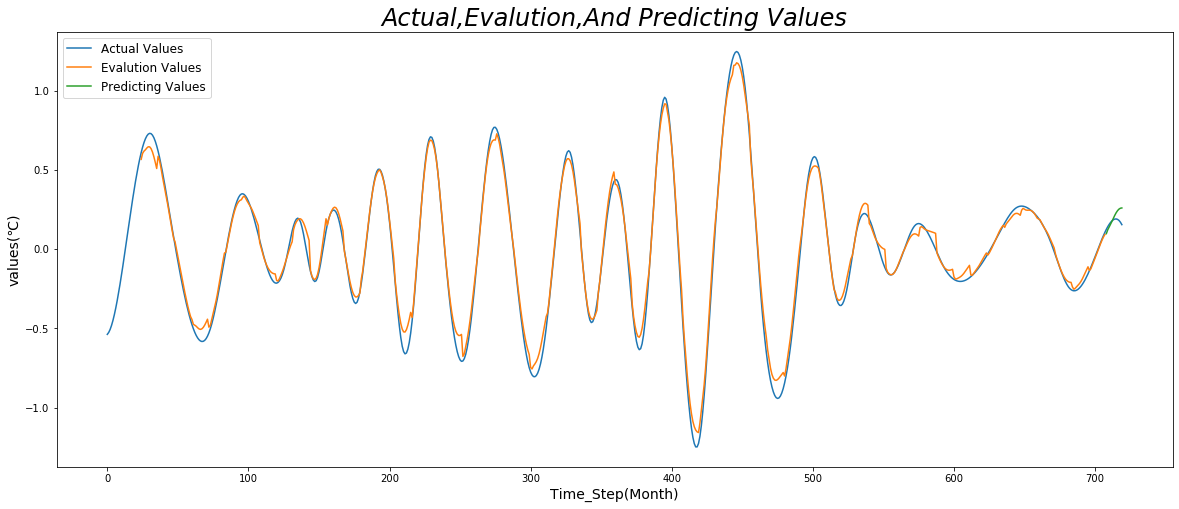

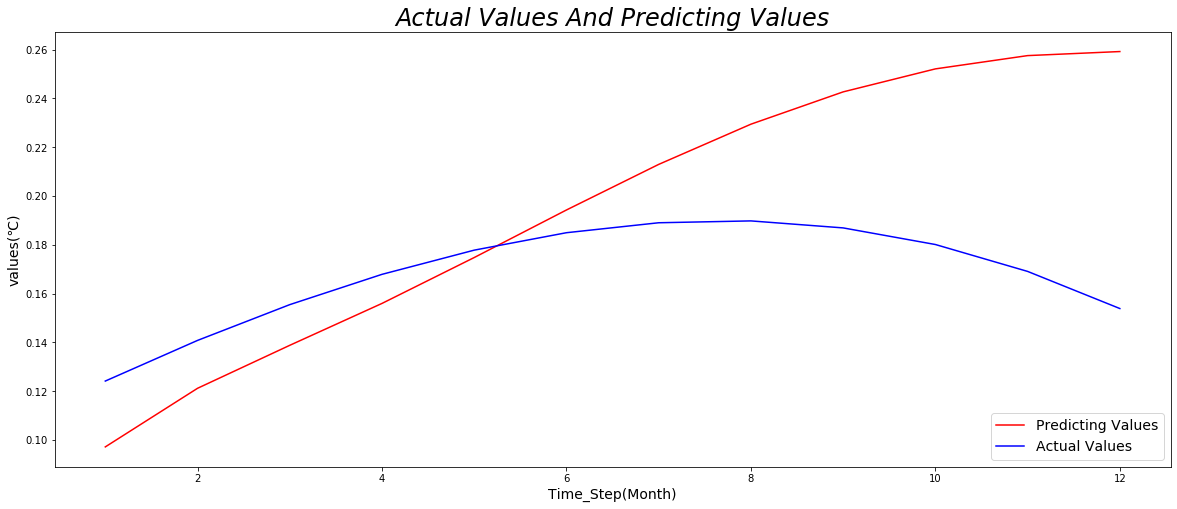

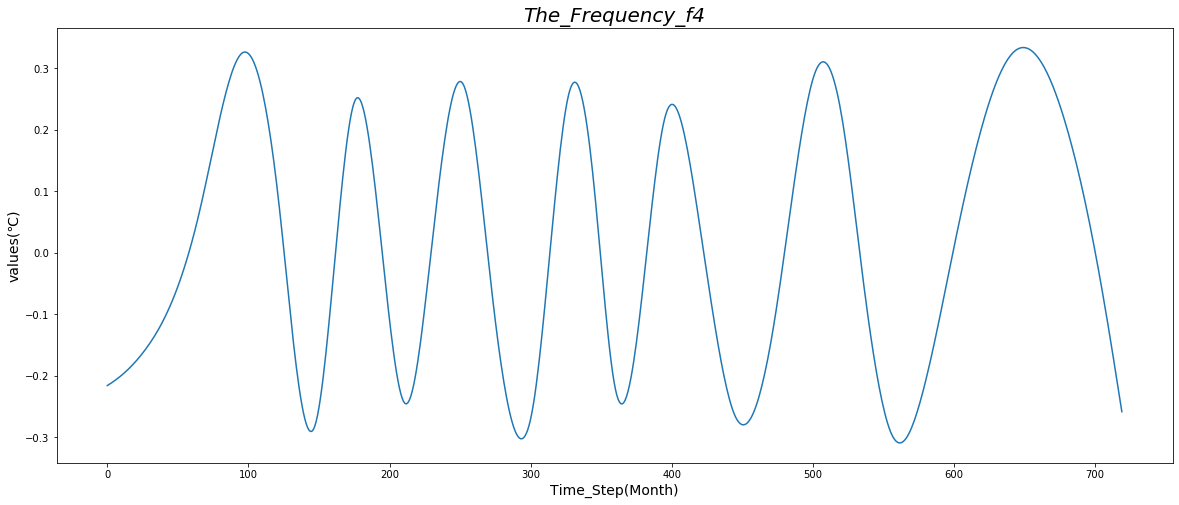

(672, 24, 1)
Epoch 1/200
 - 11s - loss: 0.0324
Epoch 2/200
 - 5s - loss: 0.0114
Epoch 3/200
 - 5s - loss: 0.0063
Epoch 4/200
 - 5s - loss: 0.0044
Epoch 5/200
 - 5s - loss: 0.0036
Epoch 6/200
 - 5s - loss: 0.0026
Epoch 7/200
 - 5s - loss: 0.0024
Epoch 8/200
 - 5s - loss: 0.0024
Epoch 9/200
 - 5s - loss: 0.0021
Epoch 10/200
 - 5s - loss: 0.0016
Epoch 11/200
 - 5s - loss: 0.0017
Epoch 12/200
 - 5s - loss: 0.0018
Epoch 13/200
 - 5s - loss: 0.0014
Epoch 14/200
 - 5s - loss: 0.0014
Epoch 15/200
 - 5s - loss: 0.0015
Epoch 16/200
 - 5s - loss: 0.0013
Epoch 17/200
 - 5s - loss: 0.0012
Epoch 18/200
 - 5s - loss: 0.0012
Epoch 19/200
 - 5s - loss: 0.0016
Epoch 20/200
 - 5s - loss: 0.0016
Epoch 21/200
 - 5s - loss: 0.0012
Epoch 22/200
 - 5s - loss: 0.0011
Epoch 23/200
 - 5s - loss: 0.0011
Epoch 24/200
 - 5s - loss: 0.0012
Epoch 25/200
 - 5s - loss: 0.0011
Epoch 26/200
 - 5s - loss: 0.0013
Epoch 27/200
 - 5s - loss: 0.0015
Epoch 28/200
 - 5s - loss: 0.0012
Epoch 29/200
 - 5s - loss: 9.7484e-04
Epoch

(57, 12)


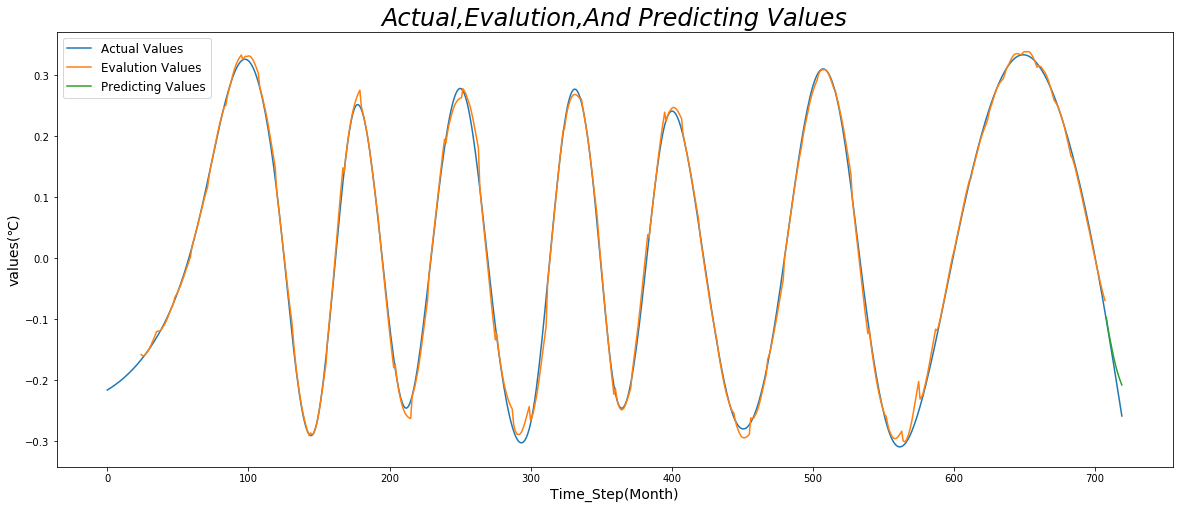

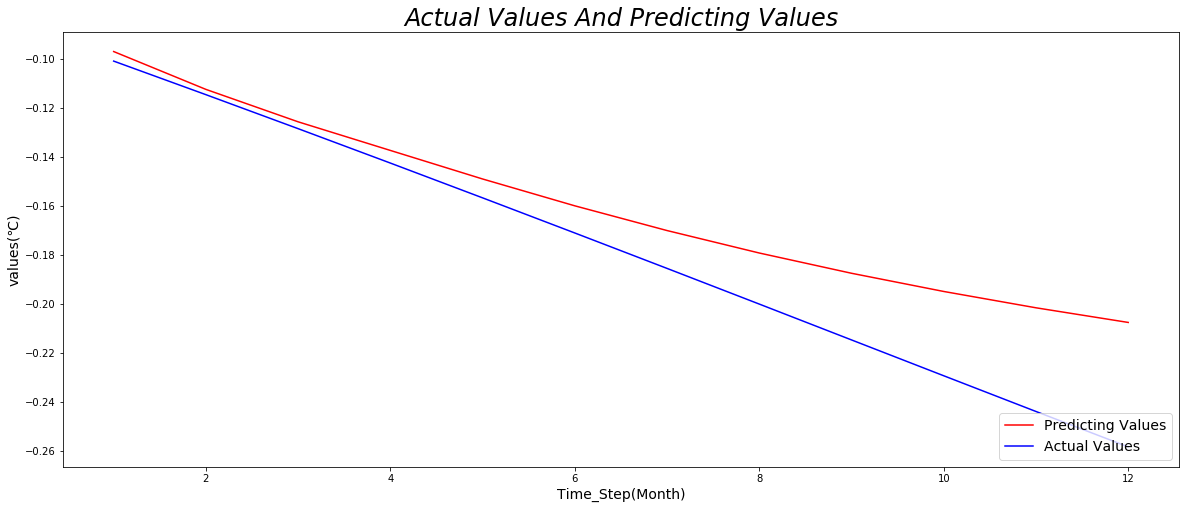

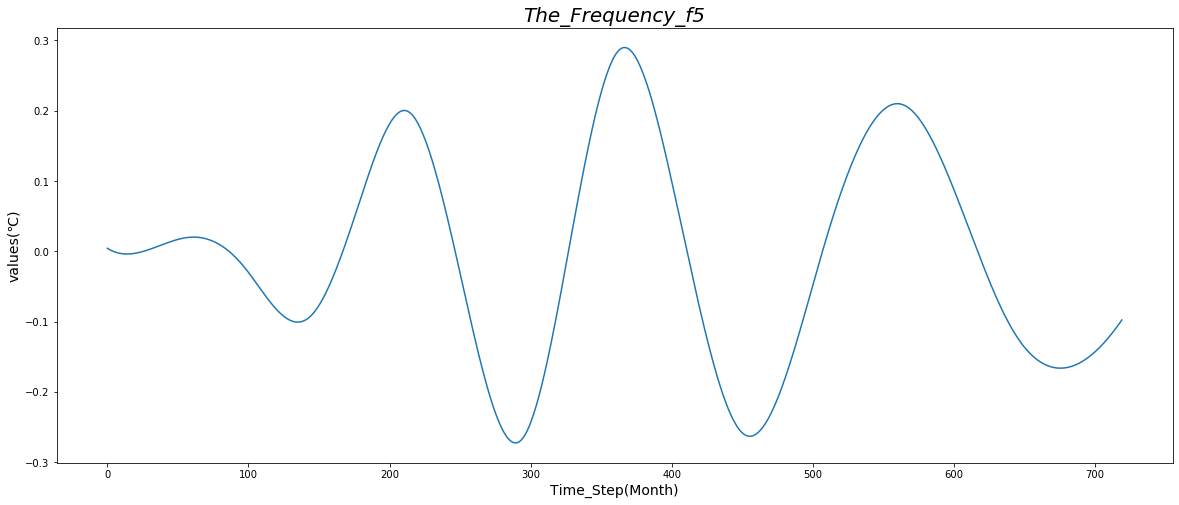

(672, 24, 1)
Epoch 1/200
 - 12s - loss: 0.0153
Epoch 2/200
 - 5s - loss: 0.0073
Epoch 3/200
 - 5s - loss: 0.0026
Epoch 4/200
 - 5s - loss: 0.0014
Epoch 5/200
 - 5s - loss: 0.0011
Epoch 6/200
 - 5s - loss: 9.1102e-04
Epoch 7/200
 - 5s - loss: 7.6229e-04
Epoch 8/200
 - 5s - loss: 4.9446e-04
Epoch 9/200
 - 5s - loss: 4.7418e-04
Epoch 10/200
 - 5s - loss: 4.3467e-04
Epoch 11/200
 - 5s - loss: 4.0876e-04
Epoch 12/200
 - 5s - loss: 4.0265e-04
Epoch 13/200
 - 6s - loss: 4.5908e-04
Epoch 14/200
 - 5s - loss: 3.9978e-04
Epoch 15/200
 - 5s - loss: 4.5999e-04
Epoch 16/200
 - 5s - loss: 4.3713e-04
Epoch 17/200
 - 5s - loss: 4.7709e-04
Epoch 18/200
 - 5s - loss: 4.0913e-04
Epoch 19/200
 - 5s - loss: 3.5620e-04
Epoch 20/200
 - 5s - loss: 3.2631e-04
Epoch 21/200
 - 5s - loss: 3.9132e-04
Epoch 22/200
 - 5s - loss: 4.7853e-04
Epoch 23/200
 - 6s - loss: 4.7855e-04
Epoch 24/200
 - 5s - loss: 3.7489e-04
Epoch 25/200
 - 5s - loss: 3.6535e-04
Epoch 26/200
 - 5s - loss: 3.9102e-04
Epoch 27/200
 - 5s - loss: 

(57, 12)


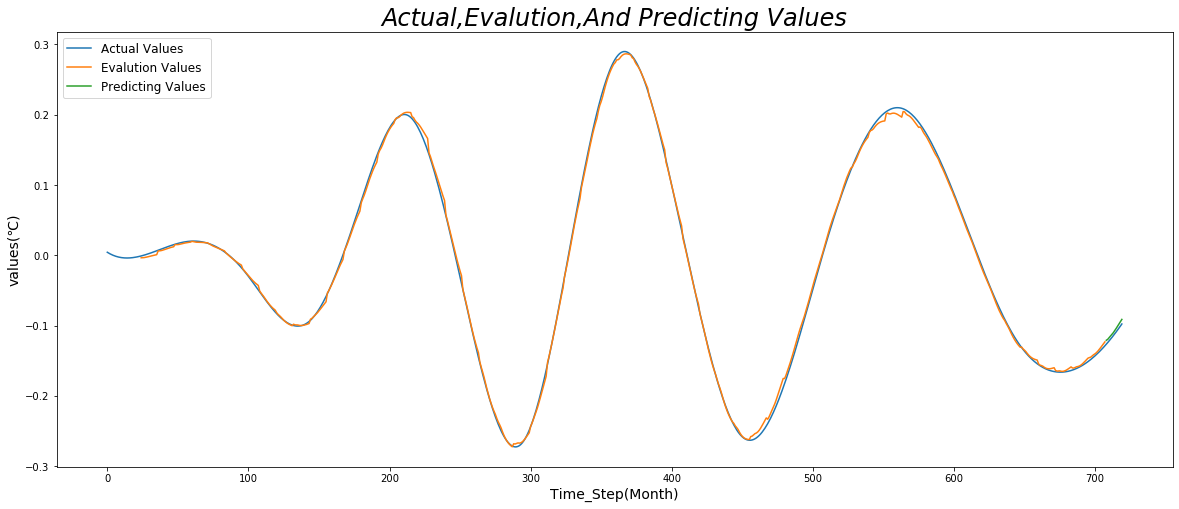

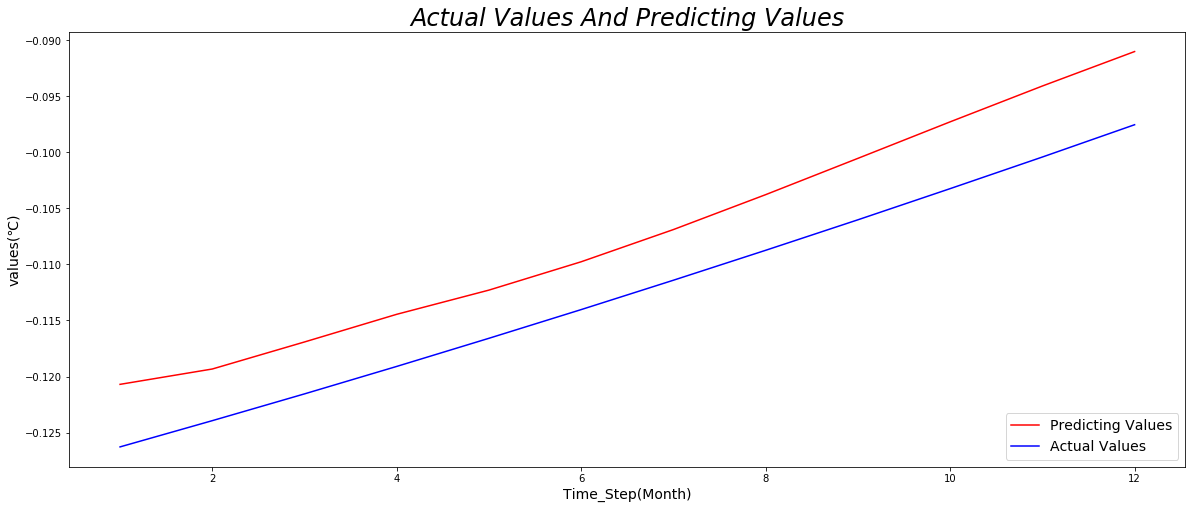

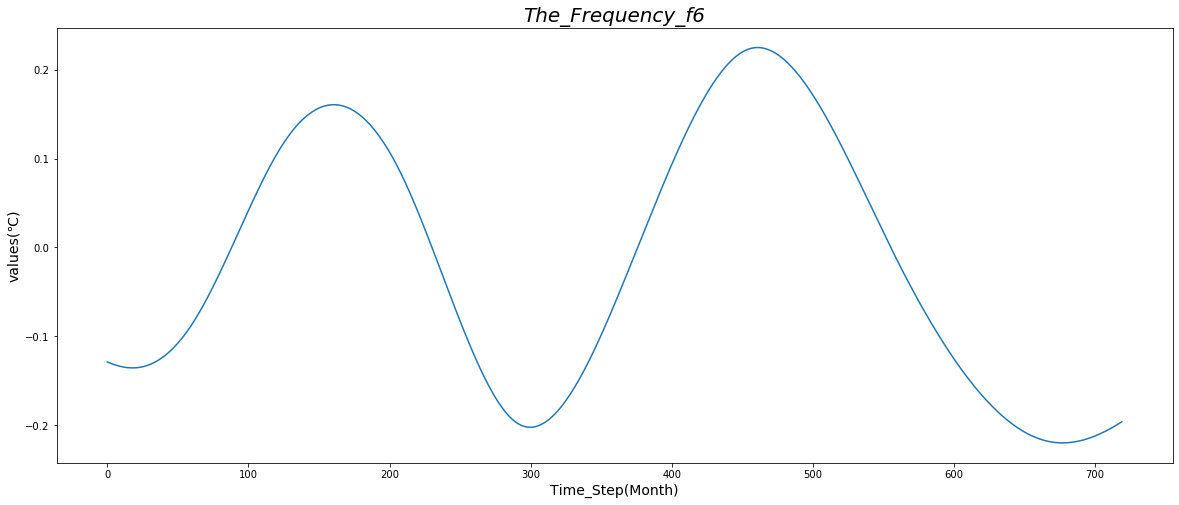

(672, 24, 1)
Epoch 1/200
 - 13s - loss: 0.0100
Epoch 2/200
 - 6s - loss: 0.0040
Epoch 3/200
 - 6s - loss: 0.0022
Epoch 4/200
 - 6s - loss: 0.0011
Epoch 5/200
 - 6s - loss: 6.3024e-04
Epoch 6/200
 - 6s - loss: 4.4509e-04
Epoch 7/200
 - 6s - loss: 4.0834e-04
Epoch 8/200
 - 6s - loss: 3.9956e-04
Epoch 9/200
 - 6s - loss: 3.2066e-04
Epoch 10/200
 - 6s - loss: 3.1352e-04
Epoch 11/200
 - 6s - loss: 3.5739e-04
Epoch 12/200
 - 6s - loss: 3.0746e-04
Epoch 13/200
 - 6s - loss: 2.8615e-04
Epoch 14/200
 - 6s - loss: 3.7870e-04
Epoch 15/200
 - 6s - loss: 3.0918e-04
Epoch 16/200
 - 6s - loss: 2.5836e-04
Epoch 17/200
 - 6s - loss: 2.4616e-04
Epoch 18/200
 - 6s - loss: 2.4380e-04
Epoch 19/200
 - 6s - loss: 2.2379e-04
Epoch 20/200
 - 6s - loss: 2.3091e-04
Epoch 21/200
 - 6s - loss: 2.6763e-04
Epoch 22/200
 - 6s - loss: 2.5607e-04
Epoch 23/200
 - 6s - loss: 2.6341e-04
Epoch 24/200
 - 6s - loss: 2.4499e-04
Epoch 25/200
 - 6s - loss: 2.3693e-04
Epoch 26/200
 - 6s - loss: 2.2235e-04
Epoch 27/200
 - 6s - lo

(57, 12)


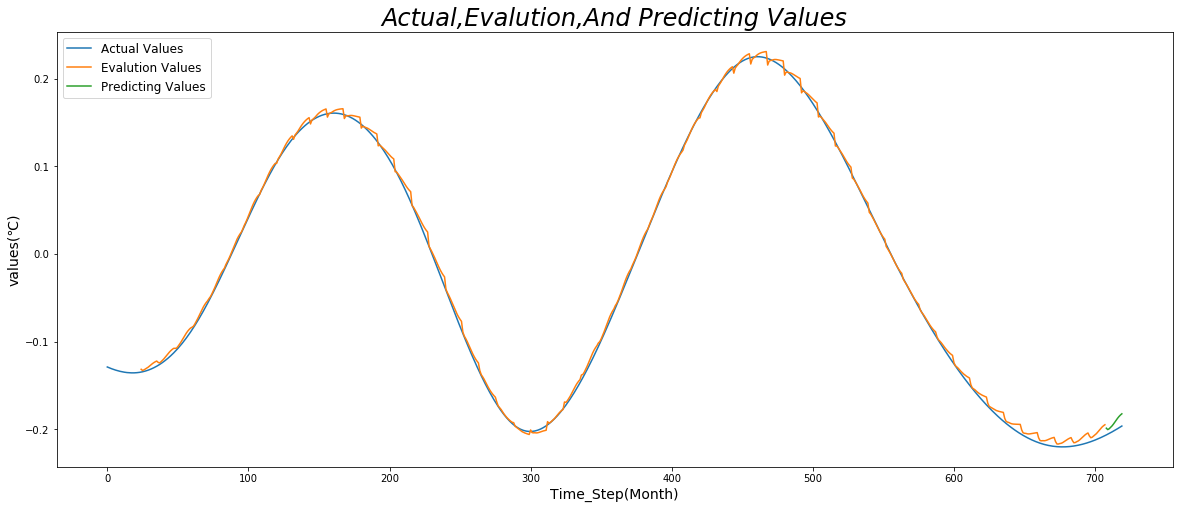

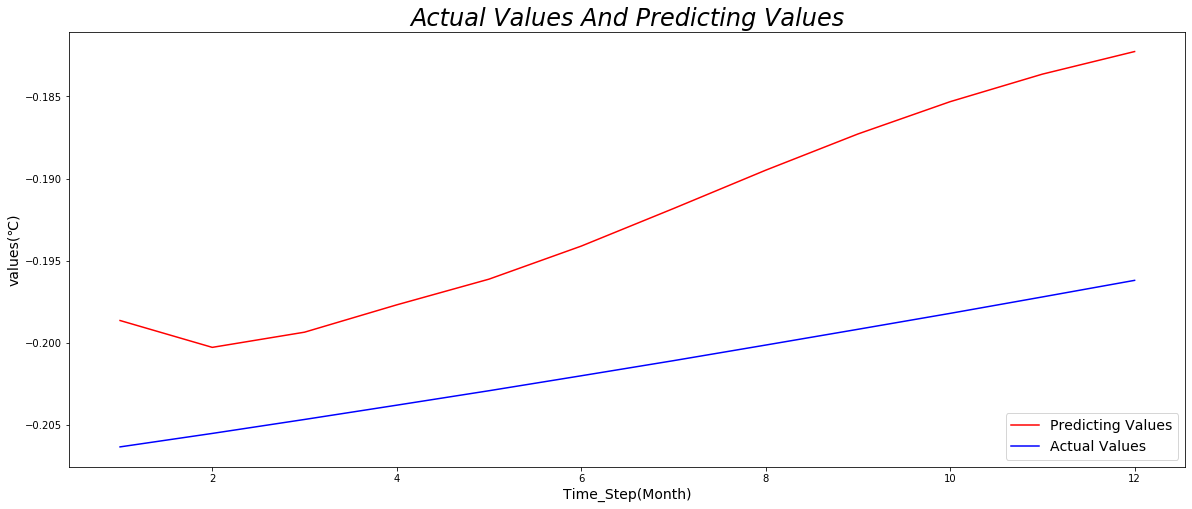

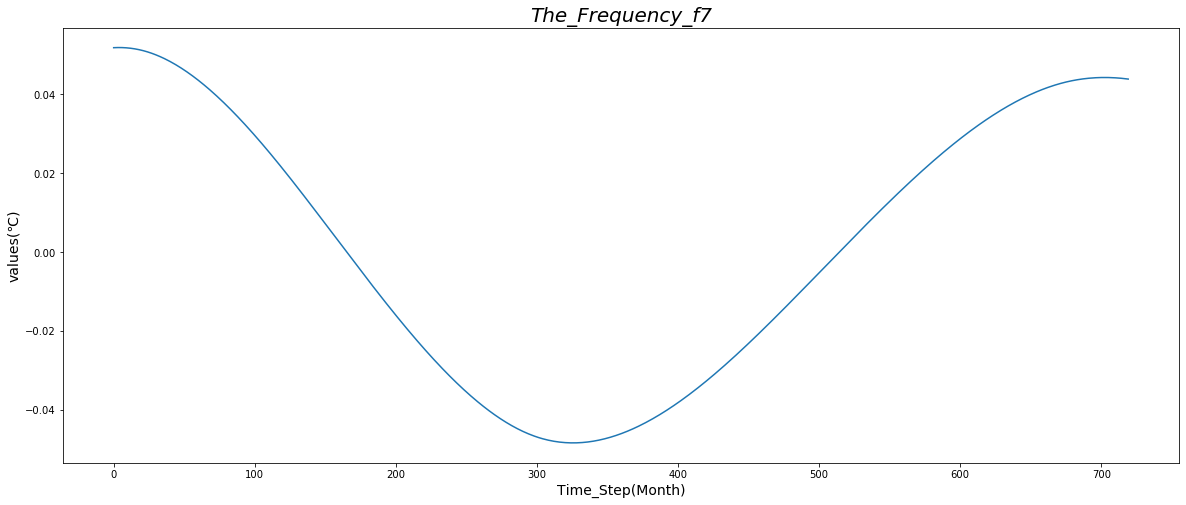

(672, 24, 1)
Epoch 1/200
 - 14s - loss: 8.5556e-04
Epoch 2/200
 - 6s - loss: 2.9369e-04
Epoch 3/200
 - 6s - loss: 1.5741e-04
Epoch 4/200
 - 6s - loss: 1.1440e-04
Epoch 5/200
 - 6s - loss: 1.0087e-04
Epoch 6/200
 - 6s - loss: 8.5152e-05
Epoch 7/200
 - 6s - loss: 6.6094e-05
Epoch 8/200
 - 6s - loss: 5.6977e-05
Epoch 9/200
 - 6s - loss: 5.1764e-05
Epoch 10/200
 - 6s - loss: 4.5202e-05
Epoch 11/200
 - 6s - loss: 4.6533e-05
Epoch 12/200
 - 6s - loss: 4.6233e-05
Epoch 13/200
 - 6s - loss: 3.7380e-05
Epoch 14/200
 - 6s - loss: 4.2232e-05
Epoch 15/200
 - 6s - loss: 3.4985e-05
Epoch 16/200
 - 6s - loss: 3.0181e-05
Epoch 17/200
 - 6s - loss: 3.0248e-05
Epoch 18/200
 - 6s - loss: 3.5725e-05
Epoch 19/200
 - 6s - loss: 2.7202e-05
Epoch 20/200
 - 6s - loss: 2.6347e-05
Epoch 21/200
 - 6s - loss: 2.1001e-05
Epoch 22/200
 - 6s - loss: 1.6417e-05
Epoch 23/200
 - 6s - loss: 1.6454e-05
Epoch 24/200
 - 6s - loss: 1.5904e-05
Epoch 25/200
 - 6s - loss: 1.8148e-05
Epoch 26/200
 - 6s - loss: 1.5347e-05
Epoch 2

(57, 12)


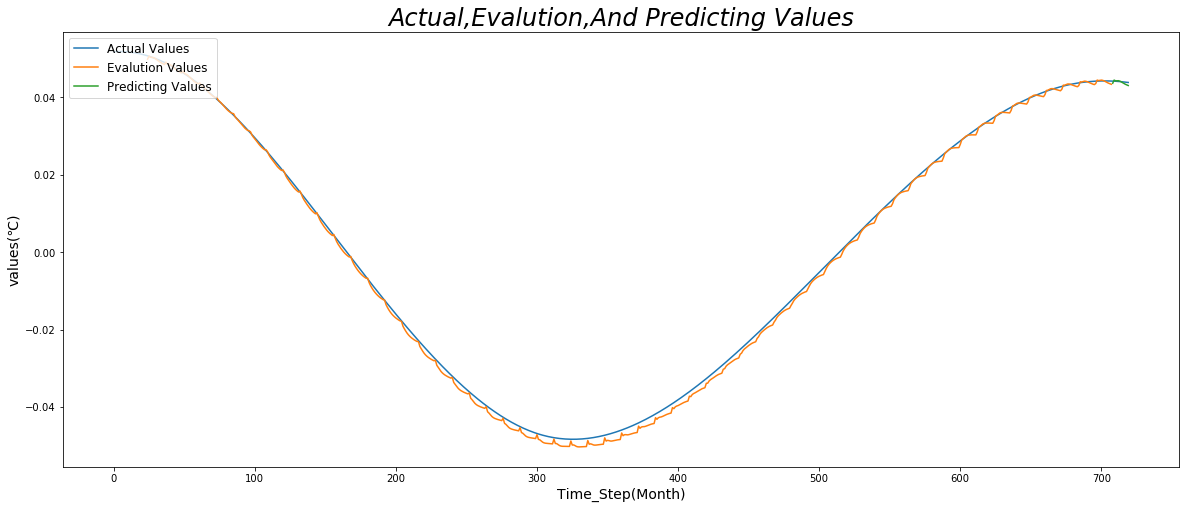

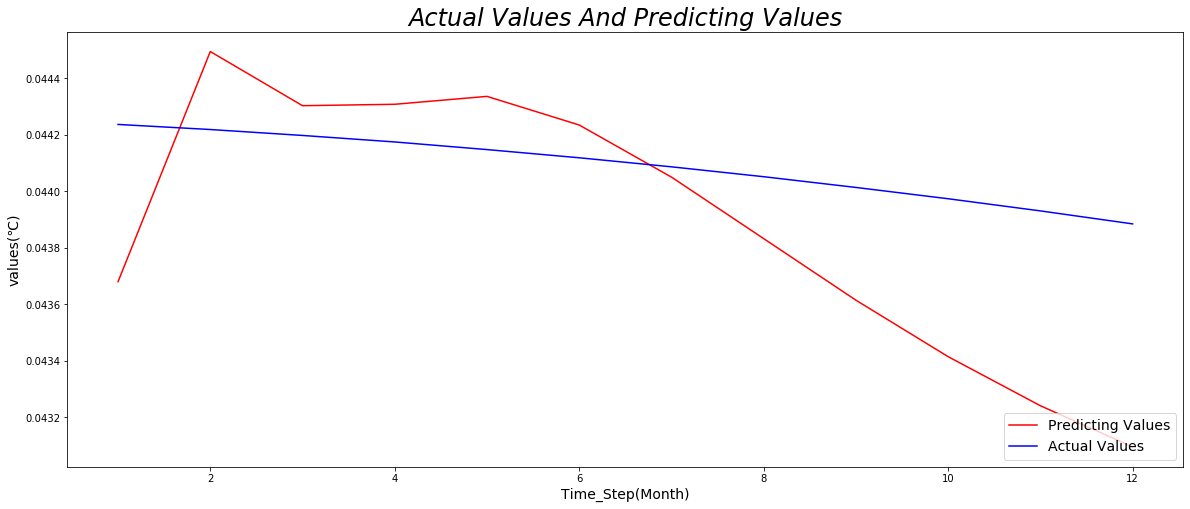

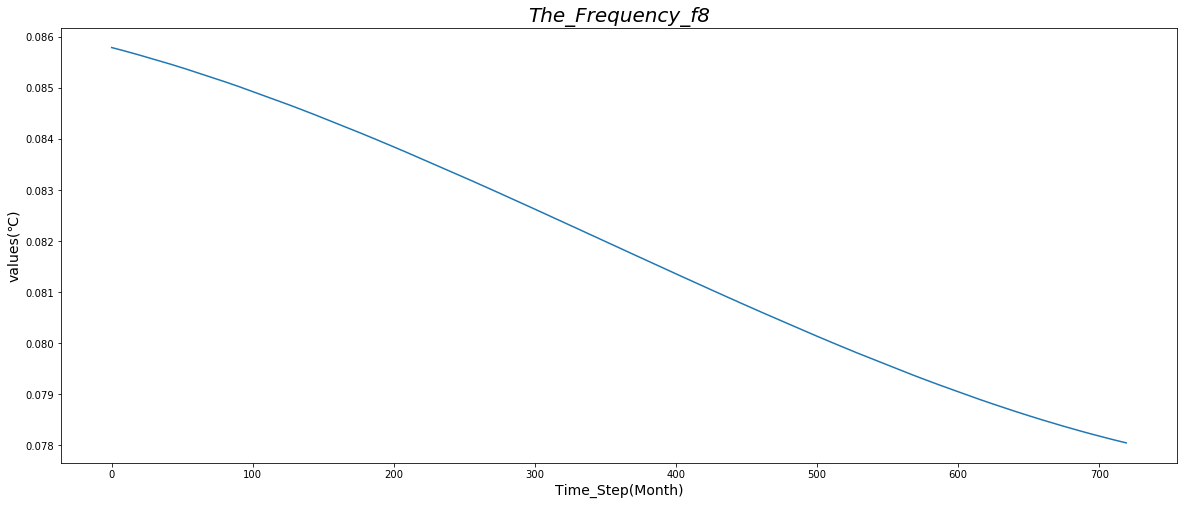

(672, 24, 1)
Epoch 1/200
 - 15s - loss: 6.0425e-04
Epoch 2/200
 - 7s - loss: 1.5497e-05
Epoch 3/200
 - 7s - loss: 8.1025e-06
Epoch 4/200
 - 7s - loss: 6.9496e-06
Epoch 5/200
 - 7s - loss: 6.4831e-06
Epoch 6/200
 - 7s - loss: 6.7993e-06
Epoch 7/200
 - 7s - loss: 7.1532e-06
Epoch 8/200
 - 7s - loss: 6.5811e-06
Epoch 9/200
 - 7s - loss: 6.2787e-06
Epoch 10/200
 - 7s - loss: 6.2645e-06
Epoch 11/200
 - 7s - loss: 5.8093e-06
Epoch 12/200
 - 7s - loss: 5.6946e-06
Epoch 13/200
 - 7s - loss: 5.6070e-06
Epoch 14/200
 - 7s - loss: 5.9661e-06
Epoch 15/200
 - 7s - loss: 6.2701e-06
Epoch 16/200
 - 7s - loss: 5.5628e-06
Epoch 17/200
 - 7s - loss: 5.7334e-06
Epoch 18/200
 - 7s - loss: 5.5588e-06
Epoch 19/200
 - 7s - loss: 6.2213e-06
Epoch 20/200
 - 7s - loss: 5.5944e-06
Epoch 21/200
 - 7s - loss: 6.0101e-06
Epoch 22/200
 - 7s - loss: 6.5949e-06
Epoch 23/200
 - 7s - loss: 5.4590e-06
Epoch 24/200
 - 7s - loss: 5.4846e-06
Epoch 25/200
 - 7s - loss: 5.4256e-06
Epoch 26/200
 - 7s - loss: 5.4087e-06
Epoch 2

(57, 12)


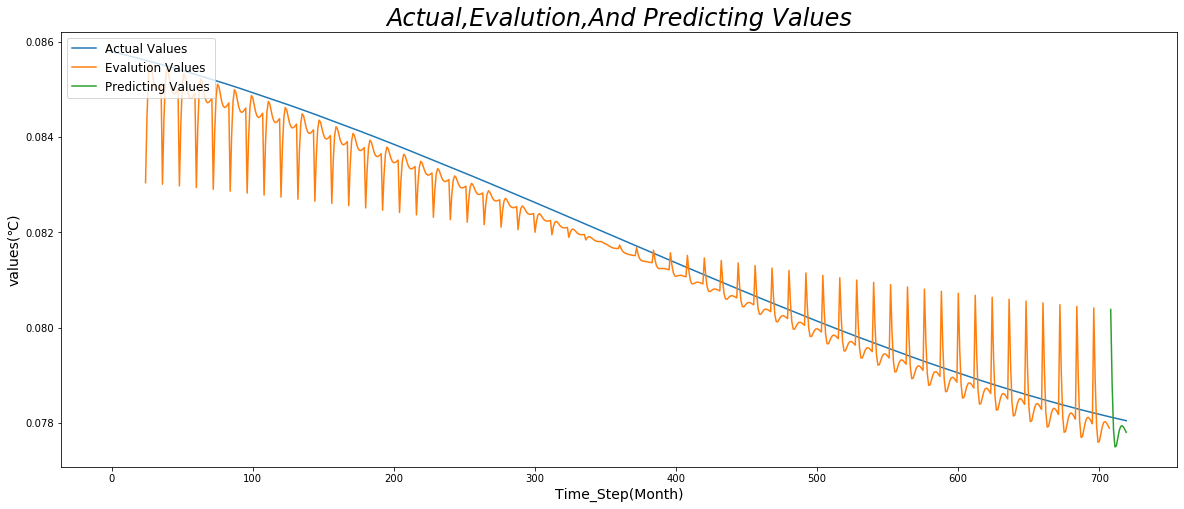

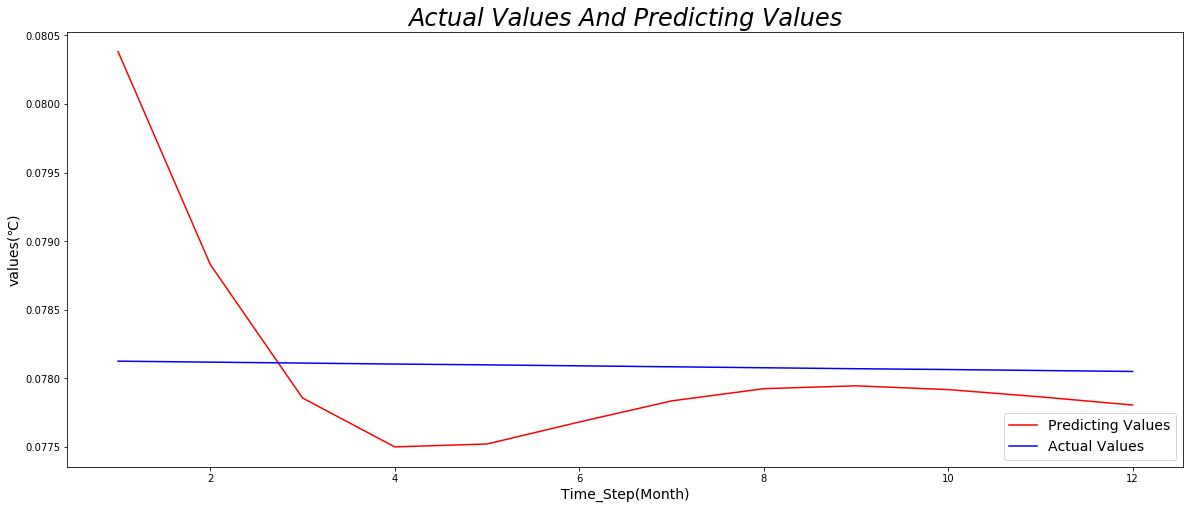

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-108]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08038176]
 [0.07882972]
 [0.07785672]
 [0.07750017]
 [0.07752112]
 [0.07768144]
 [0.07783516]
 [0.07792434]
 [0.0779453 ]
 [0.07791771]
 [0.07786493]
 [0.0778053 ]]
[array([-0.035619  ,  0.00085938,  0.048474  ,  0.1295    ,  0.16711   ,
        0.18269   , -0.0070328 , -0.27565   , -0.29169   , -0.14083   ,
        0.089041  ,  0.41071   ]), array([-0.5259  , -0.61576 , -0.61016 , -0.52834 , -0.39074 , -0.21603 ,
       -0.018192,  0.17908 ,  0.34705 ,  0.4741  ,  0.55087 ,  0.56674 ]), array([-0.05152 ,  0.095783,  0.23856 ,  0.37404 ,  0.49975 ,  0.61322 ,
        0.71198 ,  0.79356 ,  0.8555  ,  0.89532 ,  0.91051 ,  0.89881 ]), array([0.12415, 0.14081, 0.15548, 0.1679 , 0.17782, 0.18497, 0.18905,
       0.18981, 0.18694, 0.18013, 0.1691 , 0.15388]), array([-0.10086, -0.11456, -0.12844, -0.14248, -0.15668, -0.17102,
       -0.18548, -0.20004, -0.21467, -0.2293 , -0.24388, -0.25833]), array([-0.12628 , -0.12394 , -0.12155 , -0.1191  , -0.11659 , -0.11403 ,
       -0.11141 , -0.1

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.035619    0.00085938  0.048474    0.1295      0.16711     0.18269
 -0.0070328  -0.27565    -0.29169    -0.14083     0.089041    0.41071   ]
[[-0.035619  ]
 [ 0.00085938]
 [ 0.048474  ]
 [ 0.1295    ]
 [ 0.16711   ]
 [ 0.18269   ]
 [-0.0070328 ]
 [-0.27565   ]
 [-0.29169   ]
 [-0.14083   ]
 [ 0.089041  ]
 [ 0.41071   ]]
[[-0.04]
 [ 0.  ]
 [ 0.05]
 [ 0.13]
 [ 0.17]
 [ 0.18]
 [-0.01]
 [-0.28]
 [-0.29]
 [-0.14]
 [ 0.09]
 [ 0.41]]
-----------------------------------
observe value:[-0.5259   -0.61576  -0.61016  -0.52834  -0.39074  -0.21603  -0.018192
  0.17908   0.34705   0.4741    0.55087   0.56674 ]
[[-0.561519  ]
 [-0.61490062]
 [-0.561686  ]
 [-0.39884   ]
 [-0.22363   ]
 [-0.03334   ]
 [-0.0252248 ]
 [-0.09657   ]
 [ 0.05536   ]
 [ 0.33327   ]
 [ 0.639911  ]
 [ 0.97745   ]]
[[-0.56]
 [-0.61]
 [-0.56]
 [-0.4 ]
 [-0.22]
 [-0.03]
 [-0.03]
 [-0.1 ]
 [ 0.06]
 [ 0.33]
 [ 0.64]
 [ 0.98]]
-----------------------------------
observe value:[-0.05152   0.095783  0.23856   0.37404

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.01159333 -0.00728111  0.004172    0.01743994  0.0168537  -0.0080539
 -0.03667964 -0.03162289  0.01149894  0.05345606  0.05452363  0.01108411]
[-0.01159333 -0.00728111  0.004172    0.01743994  0.0168537  -0.0080539
 -0.03667964 -0.03162289  0.01149894  0.05345606  0.05452363  0.01108411]
the 1 frequence:
predicted_value:[-0.47404605 -0.5333233  -0.47371903 -0.32714885 -0.14463204  0.03084752
  0.16889948  0.25191364  0.2704417   0.22449946  0.12880298  0.01098642]
[-0.48563938 -0.5406044  -0.46954703 -0.30970892 -0.12777834  0.02279361
  0.13221984  0.22029075  0.28194066  0.27795552  0.18332662  0.02207053]
the 2 frequence:
predicted_value:[-0.01856081  0.1407351   0.3185644   0.5179078   0.7348146   0.9600936
  1.1735226   1.3456221   1.4497447   1.4813393   1.4630966   1.4223615 ]
[-0.50420019 -0.3998693  -0.15098264  0.20819888  0.60703624  0.98288723
  1.30574243  1.56591281  1.73168536  1.75929486  1.646423

[[-0.8]
 [-0.7]
 [-0.5]
 [-0.2]
 [ 0.1]
 [ 0.4]
 [ 0.5]
 [ 0.5]
 [ 0.7]
 [ 1. ]
 [ 1.3]
 [ 1.6]]
[-0.69928923 -0.5873852  -0.33193917  0.03652066  0.44628985  0.83527994
  1.17186171  1.44466953  1.62066794  1.65527225  1.54582855  1.34377002]


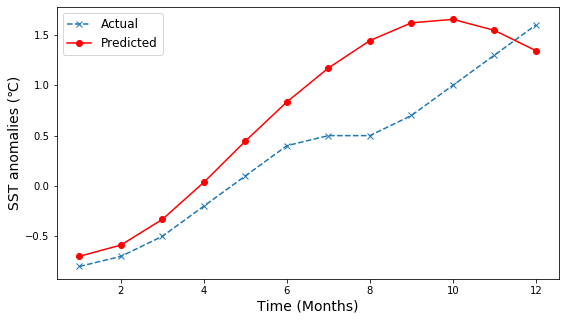

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 


In [ ]:
predicted_values=[-0.69928923,-0.5873852,-0.33193917,0.03652066,0.44628985,0.83527994,1.17186171,1.44466953,1.62066794,1.65527225,1.54582855,1.34377002]

print ("----------predicted values covert with , ----------")
converted_values=",".join(str(round(round_predicted,2)) for round_predicted in predicted_values)
print ("[{0}]".format(converted_values))
print ("---------------------------------------------------")